In [ ]:
##DOWNLOADING DATA FROM DRIVE
import glob
import os
import sys
import gdown
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/Hari/Evaluation/Diffusion")
print("Changed directory to:", os.getcwd())  # Verify the change

Changed directory to: /content/drive/MyDrive/Hari/Evaluation/Diffusion


In [ ]:
#SAVING THE .npy files into one .npz file to ease the loading process:
os.chdir("/content/drive/MyDrive/Hari/Evaluation/Diffusion/")
sys.path.append(os.path.abspath("src"))
from npy_npz2 import save_to_npz2
from dataset import LensingDataset

In [ ]:
inp_path1 = "/content/drive/MyDrive/Hari/Evaluation/Diffusion/results/train_1_3/npy"
inp_path2 = "/content/drive/MyDrive/Hari/Evaluation/Diffusion/results/train_1_3/npy1"
out_path = "/content/drive/MyDrive/Hari/Evaluation/Diffusion/results/10K_generated_samples.npz"
save_to_npz2(inp_path1,inp_path2,out_path)

Processing input_dir2:  99%|█████████▊| 7299/7400 [04:51<00:04, 25.02it/s] 


Saved dataset to /content/drive/MyDrive/Hari/Evaluation/Diffusion/results/10K_generated_samples.npz with 10000 images.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

# Load NPZ file
def load_npz_images(npz_path,key):
    x = np.load(npz_path, mmap_mode='r')
    for k in x.files:
      print(k)
    if key == 0:
      data = np.load(npz_path)['images']  # if yto accomodate two different npz-key structures
    elif key == 1:
      data = np.load(npz_path)['Samples']
    return torch.tensor(data, dtype=torch.float32)  # Convert to tensor

# Modify InceptionV3 for grayscale images (1,150,150)
class ModifiedInception(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = inception_v3(pretrained=True, transform_input=False)

        # Modify first conv layer to accept 1-channel input instead of 3
        self.model.Conv2d_1a_3x3.conv = nn.Conv2d(
            in_channels=1,
            out_channels=32,  # Keeping original filters
            kernel_size=3,
            stride=2,
            padding=0,
            bias=False
        )

        # Modify max pooling layer to handle 150x150 instead of 299x299
        self.model.fc = nn.Identity()  # Removing classification head

    def forward(self, x):
        return self.model(x)

# Compute FID Score
def calculate_fid(model, images1, images2, device="cuda", batch_size=50):  # Added batch_size
    model.eval().to(device)

    num_batches1 = len(images1) // batch_size
    num_batches2 = len(images2) // batch_size

    act1 = []
    act2 = []

    with torch.no_grad():
        for i in range(num_batches1):
            batch1 = images1[i * batch_size : (i + 1) * batch_size].to(device)
            act1.append(model(batch1).cpu().numpy())
            del batch1  # Free up memory
            torch.cuda.empty_cache()  # Empty cache

        for i in range(num_batches2):
            batch2 = images2[i * batch_size : (i + 1) * batch_size].to(device)
            act2.append(model(batch2).cpu().numpy())
            del batch2
            torch.cuda.empty_cache()

    act1 = np.concatenate(act1)  # Concatenate batch results
    act2 = np.concatenate(act2)

    # Compute mean and covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Compute mean and covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Compute FID score
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load images
gen_images = load_npz_images("/content/drive/MyDrive/Hari/Evaluation/Diffusion/results/10K_generated_samples.npz",0)  # (10000,1,150,150)
real_images = load_npz_images("/content/drive/MyDrive/Hari/Evaluation/Diffusion/data/samples.npz",1)  # (10000,1,150,150)

# Normalize and resize to match Inception
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Keep size
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale
])

gen_images = transform(gen_images)
real_images = transform(real_images)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize modified InceptionV3
model = ModifiedInception().to(device)

# Compute FID
fid_score = calculate_fid(model, gen_images, real_images, device,batch_size=50)
print(f"FID Score: {fid_score:.3f}")


images
Samples


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 148MB/s]


FID Score: 66.835


FID Score obtained through the custom FID function implementation is 66.835

In [ ]:
# Load NPZ file
def load_npz_images(npz_path,key):
    x = np.load(npz_path, mmap_mode='r')
    for k in x.files:
      print(k)
    if key == 0:
      data = np.load(npz_path)['images']  # Extract images
    elif key == 1:
      data = np.load(npz_path)['Samples']
    return torch.tensor(data, dtype=torch.float32)  # Convert to tensor

gen_images = load_npz_images("/content/drive/MyDrive/Hari/Evaluation/Diffusion/results/10K_generated_samples.npz",0)  # (10000,1,150,150)
real_images = load_npz_images("/content/drive/MyDrive/Hari/Evaluation/Diffusion/data/samples.npz",1)  # (10000,1,150,150)

images
Samples


In [ ]:
print(len(gen_images),"  ",len(real_images))

10000    10000


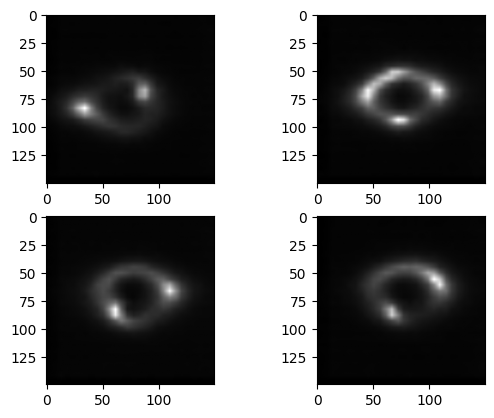

In [ ]:
img1 = gen_images[999]
def transform_img(img1):
  img1 = img1.numpy()
  img1 = np.transpose(img1,(1,2,0))
  return img1
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(transform_img(gen_images[11]),cmap='gray')
axarr[0,1].imshow(transform_img(gen_images[101]),cmap='gray')
axarr[1,0].imshow(transform_img(gen_images[1011]),cmap='gray')
axarr[1,1].imshow(transform_img(gen_images[9921]),cmap='gray')

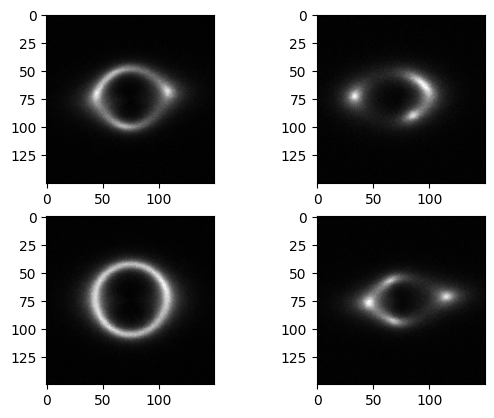

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(transform_img(real_images[0]),cmap='gray')
axarr[0,1].imshow(transform_img(real_images[10]),cmap='gray')
axarr[1,0].imshow(transform_img(real_images[100]),cmap='gray')
axarr[1,1].imshow(transform_img(real_images[1000]),cmap='gray')

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

def npy_to_png(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

    for file in os.listdir(input_folder):
        if file.endswith(".npy"):
            npy_path = os.path.join(input_folder, file)
            png_path = os.path.join(output_folder, file.replace(".npy", ".png"))

            # Load .npy file
            img_array = np.load(npy_path)

            # Convert to tensor and normalize (if needed)
            img_tensor = torch.tensor(img_array)
            #img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())  # Normalize to [0,1]

            img_pil = transforms.ToPILImage()(img_tensor)
            img_pil.save(png_path)

            # # Convert to PIL image and save
            # img_pil = Image.fromarray((img_tensor.numpy() * 255).astype(np.uint8).squeeze())
            # img_pil.save(png_path)

            print(f"Saved: {png_path}")

# Example usage
npy_to_png("/content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples", "/content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2")


Streaming output truncated to the last 5000 lines.
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample3457.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample4853.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample3434.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample3957.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample4225.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample4228.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample3466.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample4737.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample3843.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2/sample4932.png
Saved: /content/drive/MyDrive/Hari/Evaluation/Diffusion/dat

In [ ]:
!pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from pytorch_fid import fid_score

path_real = "/content/drive/MyDrive/Hari/Evaluation/Diffusion/data/Samples_png2"
path_gen = "/content/drive/MyDrive/Hari/Evaluation/Diffusion/results/train_1_3/png"

fid_value = fid_score.calculate_fid_given_paths([path_real, path_gen], batch_size=10, device="cpu", dims=2048)
print(f"FID Score: {fid_value}")

100%|██████████| 319/319 [20:49<00:00,  3.92s/it]


FID Score: 233.43811898839257


FID obatined through the official PyTorch implementation tested on 10k train images and 10k generated images is 233.43.
This is really high and is very troublesome , a good FID score needs to be below 20 , this is because I couldn't train the model for more than one training attempt of 40 epochs due to limited GPU access.
Nevertheless, I will train the model for greater number of epochs and push the consequent model weights to Github when I find time. But for now, this is the only training I performed.
Another aspect that can be attributed to this high FID Score is that due to memory issues I had to downscale the spatial dimension of the train images down to 28 and train the model with images of shape (1,28,28).
Then I sampled from this trained model and for visulalization (in the cells above and in "./results"), and also for FID calculation I upscaled the spatial dimension from 28 to 150. So technically the images generated are generated on a train set with images of spatial dimension 28.

I now wish to calculate the FID score using the input images in their downscaled dimension.This first needs me to save input images as pngs in the downscaled dimension and also save the generated images in their natural dimension without upscaling them. I will do this for a set of 1K or even just 500 images, since I will have to do this ASAP.